- Explanation of stock analysis
- time series data from stock prices
- get data
- evaluation metrics
- helper functions
- predicting stock prices w MA (20, 50, & 200 day MA)
    - Simple MA
    - Exponential MA
    - Comparison
- LSTMs for time-series
- Build LSTM model
- Results & final thoughts

## Library Imports

In [95]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras import Model, Input
from keras.layers import Dense, LSTM

## Get Data

In [92]:
def retrieve_data(ticker, span):
    tickerInfo = yf.Ticker(ticker)
    return tickerInfo.history(period=span)

ticker = "GE"
span = "20Y" #could also use 'max'
stock_prices = retrieve_data(ticker, span)

test_ratio = 0.2
train_ratio = 1 - test_ratio

train_size = int(train_ratio * len(stock_prices))
test_size = int(test_ratio * len(stock_prices))

In [93]:
stock_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5035 entries, 2003-09-22 00:00:00-04:00 to 2023-09-21 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          5035 non-null   float64
 1   High          5035 non-null   float64
 2   Low           5035 non-null   float64
 3   Close         5035 non-null   float64
 4   Volume        5035 non-null   int64  
 5   Dividends     5035 non-null   float64
 6   Stock Splits  5035 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 314.7 KB


## Evaluation Metrics

RMSE & MAPE

In [81]:
def rmse_(y_true, y_pred) -> float:
    """
    Calculate the Root Mean Squared Error 

    y_true and y_pred must be numpy arrays

    """
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse

def mape_(y_true, y_pred) -> float:
    """
    Calculate the Mean Absolute Percentage Error
    
    y_true and y_pred must be numpy arrays
    
    """
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

def calc_perf_metrics(var):
    rmse = rmse_(np.array(stock_prices[train_size:]["Close"]),
                np.array(stock_prices[train_size:][var])
    )
    
    mape = mape_(np.array(stock_prices[train_size:]["Close"]),
                np.array(stock_prices[train_size:][var])
    )
    
    return rmse, mape

## Helper Functions

In [82]:
def train_test_split(stock_data):

    train = stock_prices[:train_size][["Close"]]
    test = stock_prices[train_size:][["Close"]]

    return train, test

def get_seqX_outcomeY(data, N, offset):
    """
    Split the time-series into sequence X and its outcome Y

    data:   dataset
    N:      window size, e.g., 50 for 50 days prior
    offset: position to start split
    """
    X, y = [], []

    for i in range(offset, len(data)):
        X.append(data[i-N:i])
        y.append(data[i])
    
    return np.array(X), np.array(y)

def preprocess_testdata(data, scaler, window_size, test):

    raw = data["Close"][len(data) - len(test) - window_size:].values
    raw = raw.reshape(-1,1)
    raw = scaler.transform(raw)

    X_test = [raw[i-window_size:i,0] for i in range(window_size, raw.shape[0])]
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_test

def plot_stock_trend_ma(var, cur_title, stock_prices):
    ax = stock_prices[["Close", var, "200day"]].plot(figsize=(20,10))
    plt.grid(False)
    plt.title(cur_title)
    plt.axis("tight")
    plt.ylabel("Stock Price ($)")
    plt.show()

def plot_stock_trend_lstm(train, test):
    fig = plt.figure(figsize=(20,10))
    plt.plot(np.asarray(train.index),
             np.asarray(train["Close"]),
             label="Train Closing Price"
    )
    plt.plot(np.asarray(test.index),
             np.asarray(test["Close"]),
             label="Test Closing Price"
    )
    plt.plot(np.asarray(test.index),
             np.asarray(test["Predictions_lstm"]),
             label="Predicted Closing Price"
    )
    plt.title("LSTM Model")
    plt.xlabel("Date")
    plt.ylabel("Stock Price ($)")
    plt.legend(loc="upper left")
    plt.show()

## Simple Moving Average

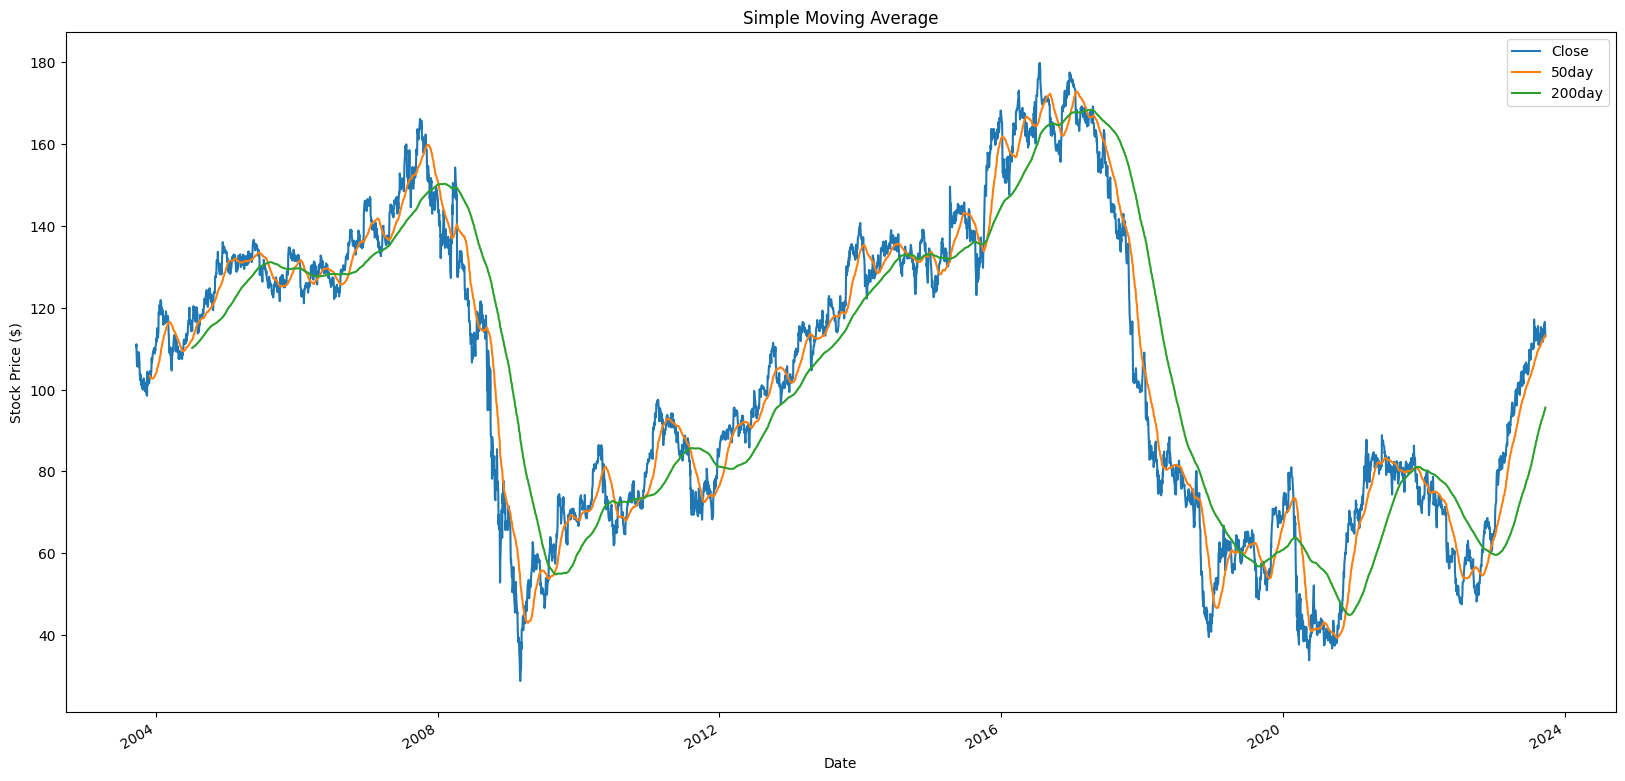

50-day SMA   RMSE: 7.212    MAPE: 8.723%


In [94]:
window_size = 50
window_var = f"{window_size}day"

stock_prices[window_var] = stock_prices["Close"].rolling(window_size).mean()
stock_prices["200day"] = stock_prices["Close"].rolling(200).mean()

plot_stock_trend_ma(var=window_var,
                 cur_title="Simple Moving Average",
                 stock_prices=stock_prices
)

rmse_sma, mape_sma = calc_perf_metrics(var=window_var)
print(f"{window_size}-day SMA   RMSE: {rmse_sma:.3f}    MAPE: {mape_sma:.3f}%")

## Exponential Moving Average

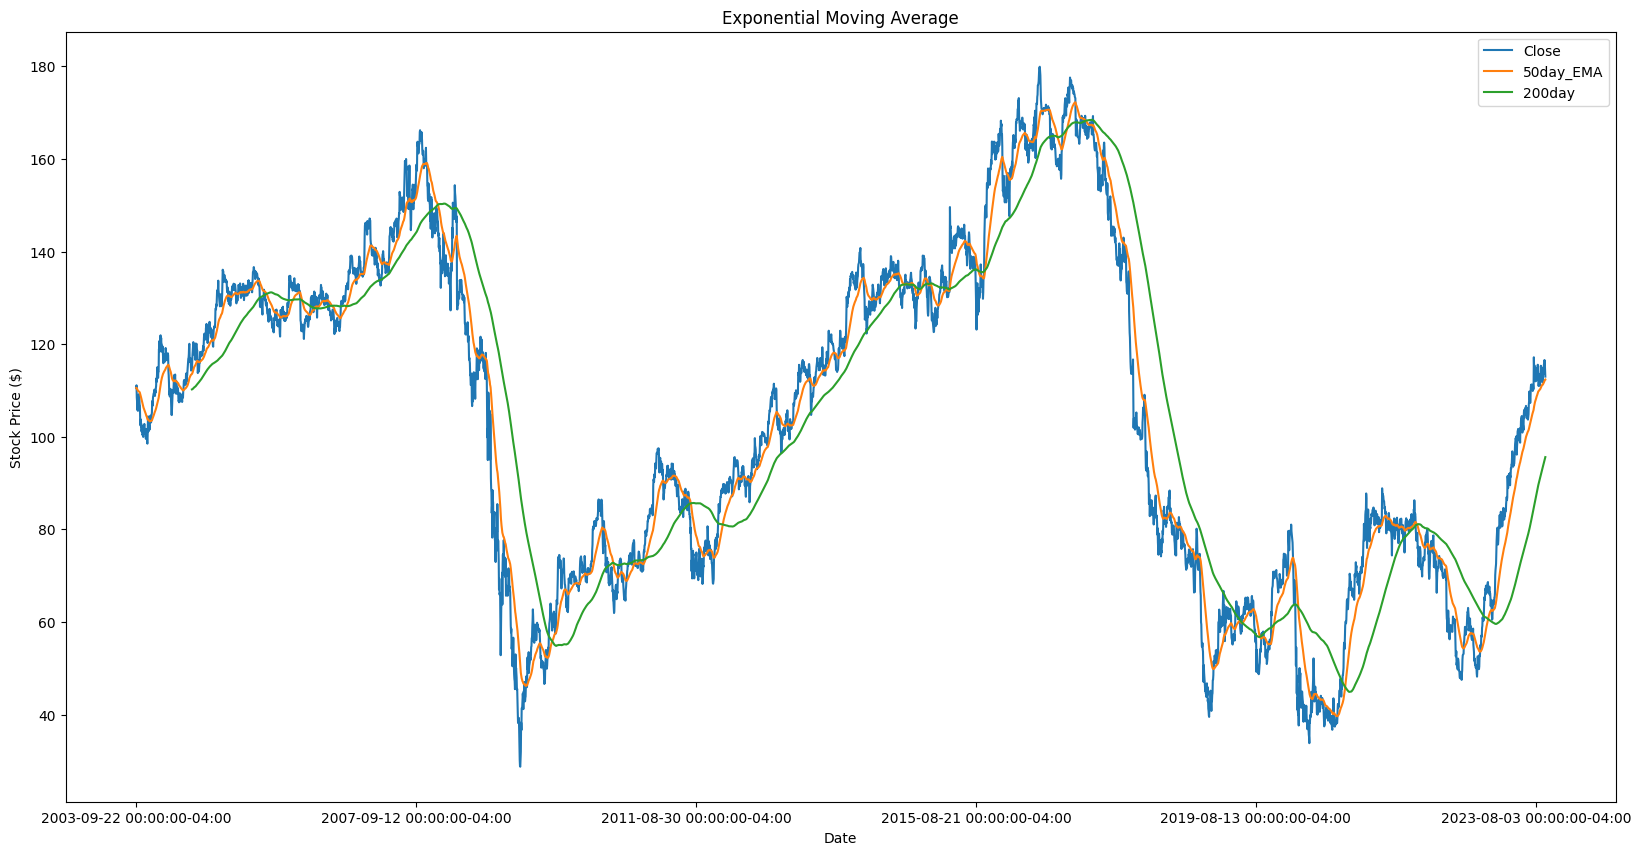

50-day EMA   RMSE: 6.37    MAPE: 7.79%


In [84]:
window_ema_var = f"{window_var}_EMA"

stock_prices[window_ema_var] = (
    stock_prices["Close"].ewm(span=window_size, adjust=False).mean()
)

plot_stock_trend_ma(var=window_ema_var,
                 cur_title="Exponential Moving Average",
                 stock_prices=stock_prices
)

rmse_ema, mape_ema = calc_perf_metrics(var=window_ema_var)
print(f"{window_size}-day EMA   RMSE: {rmse_ema:.2f}    MAPE: {mape_ema:.2f}%")

In [85]:
rmse_ema, mape_ema = calc_perf_metrics(var=window_ema_var)
print(f"{window_size}-day EMA   RMSE: {rmse_ema:.2f}    MAPE: {mape_ema:.2f}%")

50-day EMA   RMSE: 6.37    MAPE: 7.79%


## LSTM

In [86]:
n_units = 50
optimizer = "adam"
loss = "mean_squared_error"
epochs = 15
batch_size = 20

In [87]:
def run_lstm(X_train):

    input = Input(shape=(X_train.shape[1], 1))
    hidden1 = LSTM(units=n_units, return_sequences=True)(input)
    hidden2 = LSTM(units=n_units)(hidden1)
    output = Dense(1, activation="linear")(hidden2)

    model = Model(input, output)
    model.compile(loss=loss, optimizer=optimizer)

    return model

In [88]:
scaler = StandardScaler()
closing_prices = np.array(stock_prices["Close"]).reshape(-1,1)
scaled_data = scaler.fit_transform(closing_prices)

train, test = train_test_split(stock_data=stock_prices)

scaled_training_data = scaled_data[:train.shape[0]]

X_train, y_train = get_seqX_outcomeY(scaled_training_data,
                                     window_size,
                                     window_size)

In [89]:
model = run_lstm(X_train)

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_split=0.1,
                    shuffle=True
)

Epoch 1/15
179/179 [==============================] - 11s 36ms/step - loss: 0.0368 - val_loss: 0.0112
Epoch 2/15
179/179 [==============================] - 6s 34ms/step - loss: 0.0095 - val_loss: 0.0102
Epoch 3/15
179/179 [==============================] - 6s 31ms/step - loss: 0.0079 - val_loss: 0.0093
Epoch 4/15
179/179 [==============================] - 6s 32ms/step - loss: 0.0067 - val_loss: 0.0070
Epoch 5/15
179/179 [==============================] - 6s 36ms/step - loss: 0.0060 - val_loss: 0.0066
Epoch 6/15
179/179 [==============================] - 6s 34ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 7/15
179/179 [==============================] - 6s 32ms/step - loss: 0.0047 - val_loss: 0.0071
Epoch 8/15
179/179 [==============================] - 6s 32ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 9/15
179/179 [==============================] - 6s 31ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 10/15
179/179 [==============================] - 6s 32ms/step - loss: 0.0032 - val_l

In [90]:
X_test = preprocess_testdata(data=stock_prices,
                             scaler=scaler,
                             window_size=window_size,
                             test=test
)

preds_ = model.predict(X_test)
preds = scaler.inverse_transform(preds_)

test["Predictions_lstm"] = preds

32/32 [==============================] - 1s 15ms/step


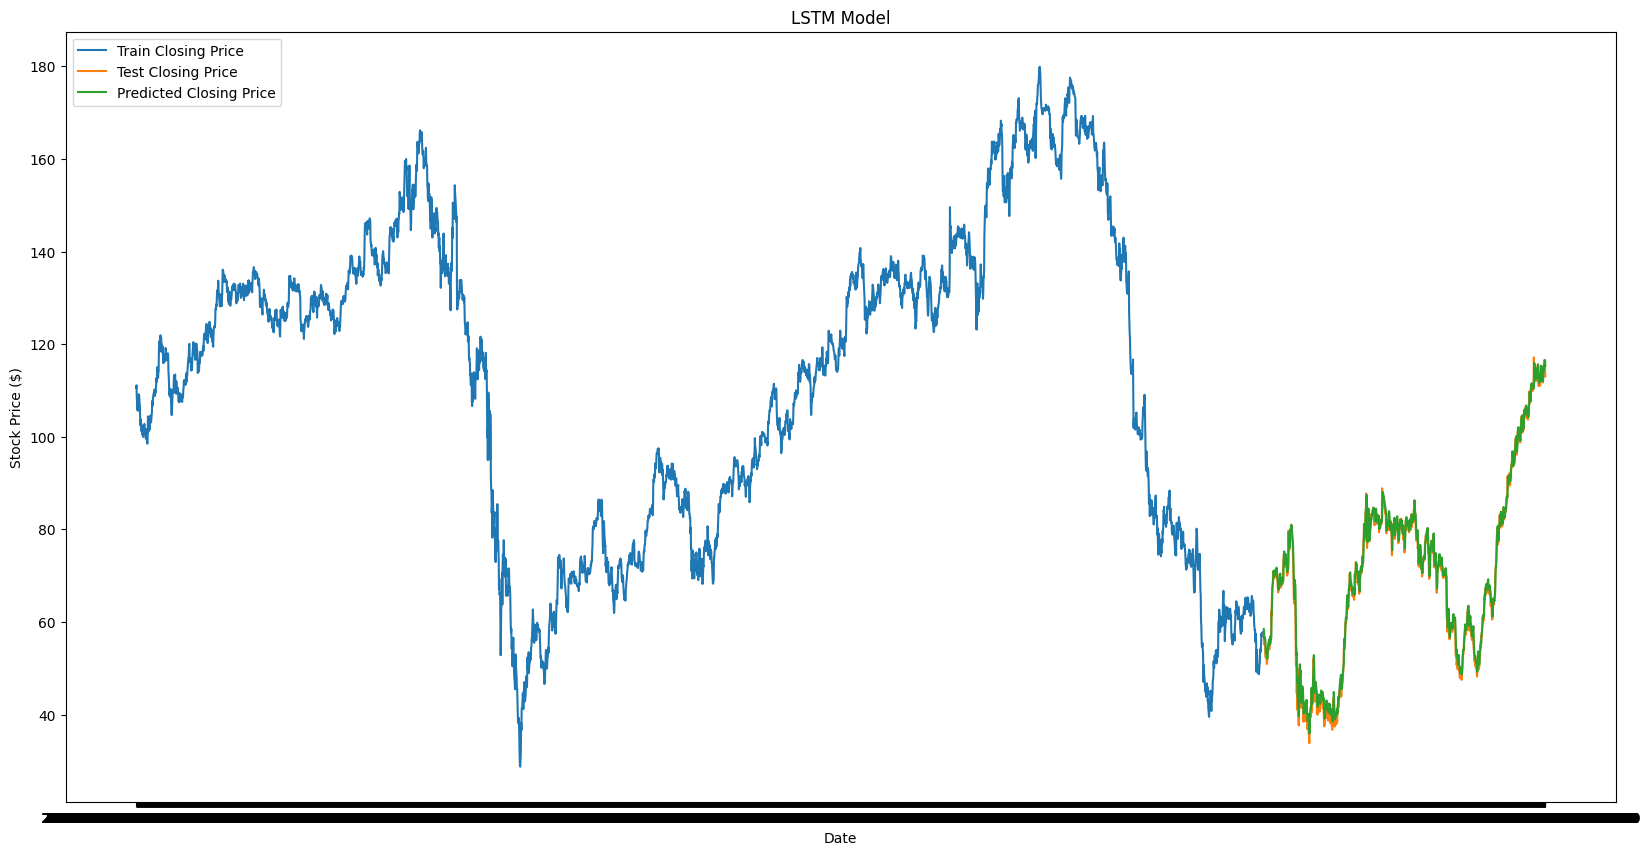

50-day LSTM   RMSE: 1.77    MAPE: 2.19%


In [91]:
plot_stock_trend_lstm(train=train, test=test)

rmse_lstm = rmse_(np.array(test["Close"]), np.array(test["Predictions_lstm"]))
mape_lstm = mape_(np.array(test["Close"]), np.array(test["Predictions_lstm"]))

print(f"{window_size}-day LSTM   RMSE: {rmse_lstm:.2f}    MAPE: {mape_lstm:.2f}%")